# Introduction

## Computer Preliminaries and Error Descriptors

Unfortunately computers can't store numbers with infinite precision, but instead use an approximation that can be packed into a fixed number of bits.  These bits can be arranged to represent different data types usually called fixed point numbers or integers and floating point numbers.  Of most importance to us as numerical analysts are floating point numbers.  

A floating point number is represented within the computer as a bit sign (positive or negative), an integer number representing the number of significant digits called the significand or mantissa, and an integer exponent.  Symbolically, we might write:

$$
s \times M \times B^{sE}
$$

where, $s$ is the sign, $M$ is the mantissa, $B$ is called the base usually $2$, but sometimes $10$ or $16$, and $E$ is the integer exponent.

The smallest floating point number which, when added to the floating point number $1.0$, produces a result different than $1.0$ is called the machine precision or machine epsilon, $\epsilon_{m}$.  Most modern computers have a machine epsilon value somewhere around $2^{-53}$ $(1.11 \times 10^{-16})$, although $\epsilon_{m}$ can range depending on the base and the bit wordlength (32-bit, 64-bit, etc.)

Almost any arithmetic between floating point numbers will produce an additional fraction error of size $\epsilon_{m}$, this error is called roundoff error.  Numpy has a special function that can report what $\epsilon_{m}$ is for the machine we are using: 

In [1]:
import numpy as np
eps = np.finfo(np.float).eps;  eps

2.220446049250313e-16

We can verify that adding $\epsilon_m$ to 1.0 returns something that differs from 1.0.

In [2]:
1.0 + eps != 1.0

True

However dividing $\epsilon_m$ by 10 and adding to 1.0 simply returns 1.0.

In [3]:
1.0 + eps / 10 == 1

True

## The Numerical Analyst's Enemy:  Roundoff Error

Roundoff error, is a characteristic of computer hardware; however, there is another type of error that is completely a result of the algorithm or software.

Most numerical algorithms compute discrete approximations to a continuous desired quantity.  An example of this is the use of the Taylor series to approximate the function $\sin{(x)}$. The Taylor series approximation of the function is as follows:

$$
\sin{(x)} = x - \frac{x^3}{3!}+\frac{x^5}{5!}-\frac{x^7}{7!} \cdots 
$$

Of course, this representation requires that the series be infinite for the solution to be exact.  Even the best computers cannot evaluate an infinite number of terms in the Taylor series; therefore, we must take a finite number of terms for the approximation.  The difference between the approximated answer and the exact solution is called the truncation error.  Let's take a look at some numerics, we all know that $\sin{\left(\frac{\pi}{2}\right)} = 1$.

We start by defining a function representing the Taylor series expansion of $\sin(x)$.

In [4]:
import sympy
sympy.init_printing()
x = sympy.Symbol('x')

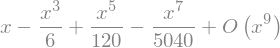

In [5]:
taylor_sin = lambda N=9: sympy.series(sympy.sin(x),x,n=N);
taylor_sin()

By evaluating the function above at $x = \frac \pi 2$ and subtracting it from 1 we can see how the truncation error evolves as we add more terms in the Taylor series.

In [6]:
from ipywidgets import interact, interactive, IntSlider
from IPython.display import display, Markdown, HTML, Math

display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
             "latest.js?config=default'></script>"))


def taylor_sin_minus_one(N):
    display(1 - taylor_sin(N).removeO())
    display(Markdown("Error = {}"
                     .format(sympy.latex(1 - taylor_sin(N).removeO().subs(x, np.pi / 2).evalf(), mode='inline'))))
          
interactive_sin = interactive(taylor_sin_minus_one, N=IntSlider(min=1, max=20, description='No. of Terms:'))
output = interactive_sin.children[-1]
output.layout.height = '75px'
interactive_sin

interactive(children=(IntSlider(value=1, description='No. of Terms:', max=20, min=1), Output(layout=Layout(hei…

Here is an interesting visualization of how the difference between the two functions evolve as we add more terms of the Taylor series. The truncation error is visualized as the maximum difference between the two curves.

In [7]:
import matplotlib
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']

def interactive_sin_plot(N=3):
    
    display(1 - taylor_sin(N).removeO())
    
    xx = np.linspace(0, 2*np.pi)
    
    ts = lambdify(x, taylor_sin(N).removeO(), 'numpy')
    
    fig, ax = plt.subplots()
    ax.plot(xx, np.sin(xx))
    ax.plot(xx, ts(xx))
    ax.set_ylim([-1.5, 1.5])
    plt.grid()
    
    plt.show()
    plt.close(fig)
    
interactive_sin_plot = interactive(interactive_sin_plot, N=IntSlider(min=3, max=20, description='No. of Terms:'))
output = interactive_sin_plot.children[-1]
output.layout.height = '320px'
interactive_sin_plot

interactive(children=(IntSlider(value=3, description='No. of Terms:', max=20, min=3), Output(layout=Layout(hei…

The minimization of truncation error is one of the main goals of numerical analysis.

## Stability

Usually roundoff error and truncation error do not interact with each other, but sometimes roundoff error can cause a numerical algorithm to become *unstable*. This happens when roundoff error gets mixed into the calculation and is magnified as it continues. Let's look at an example:

Suppose we want to calculate the powers of the so called "Golden Mean"

$\phi = \frac{\sqrt{5}-1}{2}$

It can be verified that the power of $\phi^{n+1}$ can be calculated using the simple recusion relationship,

$\phi^{n+1} = \phi^{n-1} - \phi^n$

Therefore by calcuating $\phi^0 = 1$ and $\phi^1 = 0.618034$ and successively applying the recusion relationship we should be able to calculate as many powers as desired. Let's see this in action:

First we'll calculate what we will call the "exact" answer by actually evaluating all the power individually.



In [8]:
phi_exact = (np.sqrt(5) / 2 - 1 / 2) ** np.arange(80)

Next we will calculate the first 2 powers and use the recursion formula to evaluate the rest.

In [9]:
phi_recursion = np.zeros(80)
phi_recursion[0] = 1
phi_recursion[1] = (np.sqrt(5) / 2 - 1 / 2)

for n in range(1,79):
    phi_recursion[n + 1] = phi_recursion[n - 1] - phi_recursion[n]

Visualizing the results of these two methods.

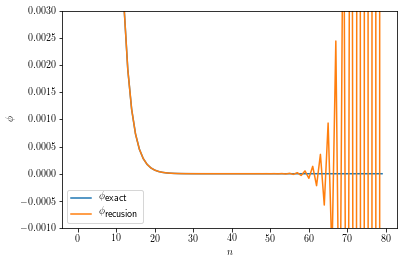

In [10]:
fig, ax = plt.subplots()
ax.plot(phi_exact, label=r'$\phi_{\mbox{exact}}$')
ax.plot(phi_recursion, label=r'$\phi_{\mbox{recusion}}$')
ax.set_ylim([-0.001, 0.003])
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$n$')
ax.legend();

The recusion relationship is unstable and cannot be used as stated to solve this problem. Stability of algorithms is something we always need to be aware of as numerical analysts.

## Psuedocode
Psuedocode is a compact and informal way of describing a numerical algorithm. It utilizes the conventional structure of a programming language (loops, conditional statements, etc.) but is intended for human reading.

## Conventional Programming Structures
**Do Loops and For Loops:** These two structures essentially do the same thing in a slightly different way. They are used when you want to do something in sequance for a set number of iterations. Let's look at a couple of examples using Python.

In [11]:
for i in range(0,10,2):
    print(i)

0
2
4
6
8


**While Loops:** These loops are used to evaluate the body of the loop as long as a certain test is passed. An example would be:

In [12]:
i = 0
while i < 10:
    print(i)
    i = i+2

0
2
4
6
8


**If Statements:** Used as tests to return different actions. An example of an 'if statement' is:

In [13]:
i = 2
if i == 1:
    print('i is equal to 1')
else:
    print('i is not equal to 1')

i is not equal to 1


When we write sophisticated code we might use multiple loops and if statements in conjunction. For instance:

In [14]:
i = 0
while i < 3:
    if i == 1:
        print('i is equal to 1')
    else:
        print('i is not equal to 1, i is {}'.format(i))
    i = i+1

i is not equal to 1, i is 0
i is equal to 1
i is not equal to 1, i is 2
